# MNIST Tensorflow 2
This is an example of building a multi-layer network in Tensorflow 2 to solve the MNIST problem.
The objective is to be low-level enough to understand the operation on a layer-by-layer,
matrix operation level.

In [ ]:
#install tensorflow module
!pip install tensorflow

In [28]:
import tensorflow as tf;
import numpy as np;
import time;
import sys;
import matplotlib.pyplot as plt

# the only place where I want to use Keras
mnist = tf.keras.datasets.mnist;
#mnist = tf.keras.datasets.fashion_mnist;

(x_train, y_train), (x_test, y_test) = mnist.load_data();

In [29]:
# show the shapes of the data
print( "Training set input data:          ", x_train.shape );
print( "Training set output (target) data:", y_train.shape );
print( "Test set input data:              ", x_test.shape );
print( "Test set output (target) data:    ", y_test.shape );

Training set input data:           (60000, 28, 28)
Training set output (target) data: (60000,)
Test set input data:               (10000, 28, 28)
Test set output (target) data:     (10000,)


In [30]:
##########################################################################

# some short-cut names

EPS = np.finfo(np.double).eps
sigmoid = tf.nn.sigmoid
softmax = tf.nn.softmax
vs_init = tf.initializers.GlorotUniform()
zeros_init = tf.zeros
DTYPE = tf.float32

##########################################################################

##########################################################################

class Layer:
    """
    This respresents a layer in a neural network.

    It's attributes are:
        params   - a dictionary of parameters for the network,
        name     - a name given to the Layer,
        node_no  - the number of nodes in the Layer,
        transfer - the transfer function used by the nodes in the Layer,
        inputs   - an incoming WeightLayer that provides inputs to this Layer,
        outputs  - an outgoing WeightLayer that receives the outputs of this
                   Layer,
        biases   - a tf.Variable that holds the output bias values for
                   this Layer.
    """

    def __init__( self, PARAMETERS, name, node_no, transfer ):
        """
        Constructor function that sets object attributes to match
        arguments, sets the outputs attribute to None, and initalizes
        the biases.
        """
        self.params   = PARAMETERS;
        self.name     = name;
        self.node_no  = node_no;
        self.transfer = transfer;
        self.inputs   = None;
        self.outputs  = None;
        self.biases   = tf.Variable(
                              self.params['BIAS_INIT']( [ self.node_no ],
                                                        dtype=DTYPE ),
                              name='B_%s' % (self.name,),
                              trainable=True );

    def __rshift__( self, other ):
        """
        This overloads the right shift operator (>>) to allow users
        to create a network by connecting two Layers together.
        e.g. input_layer >> hidden_layer >> output_layer
        """
        return NN(self,other);  # create NN object consisting of
                                # current layer and other layer

    @tf.function
    def output( self, input ):
        """
        Create decorated function to compute the activation values
        of the neurons in this Layer.

        input is the input to the entire NN.

        This is the main operation of a Layer.  It adds the "net" values
        of the units (i.e. the outputs of "inputs" WeightLayer) to the
        units' bias values, and applies a transfer function.
        """
        return self.transfer( tf.nn.bias_add(
                                    self.inputs.output(input),
                                    self.biases ) );

    # @tf.function
    # This function cannot be decorated because it won't work with the tape
    def update( self, loss, tape ):
        gradient = tape.gradient(loss, self.biases)
        if gradient is not None:  # Check if gradient is not None
            gradient = tf.clip_by_value(gradient, -0.5, 0.5)
            self.biases.assign(self.biases - self.params['LEARNING_RATE'] * gradient)
            self.biases.assign(tf.clip_by_value(self.biases, -10.0, 10.0))

##########################################################################

class InputLayer(Layer):
    """
    Special subclass of Layer that is an input layer.

    It's transfer, inputs, init, and outputs attributes are all undefined.

    It's attributes are:
        params   - a dictionary of parameters for the network,
        name     - a name given to the Layer,
        node_no  - the number of nodes in the Layer.

    It overrides the __init__ and output functions.
    It inherits __rshift__ from Layer.
    """
    def __init__( self, PARAMETERS, name, node_no ):
        """
        Constructor function that sets object attributes to match
        arguments.
        """
        self.params   = PARAMETERS;
        self.name     = name;
        self.node_no  = node_no;

    @tf.function
    def output( self, inputs ):
        """
        Create decorated function to compute the activation values
        of the neurons in this InputLayer.

        It just returns the passed inputs value.
        """
        return inputs;

    # @tf.function
    # This function cannot be decorated because it won't work with the tape
    def update( self, loss, tape ):
        """
        Do nothing.
        """
        pass;

##########################################################################

class WeightLayer:
    """
    This class represents a layer of weights between two Layers of
    neurons.

    It has the following attributes:
        params  - a dictionary of parameters for the network,
        src     - a Layer or InputLayer of neurons that passes activation
                  values through the WeightLayer,
        name    - a name given to the WeightLayer,
        dest    - a Layer of neurons that receives a signal
                  from the WeightLayer.
        weights - a tf.Variable that holds the weight values for
                  this WeightLayer.
    """

    def __init__( self, PARAMETERS, src, dest ):
        """
        Constructor function that sets object attributes to match
        arguments.

        It also sets the name based on the src.name and dest.name
        and initializes weights.
        """
        self.params  = PARAMETERS;
        self.src     = src;
        self.name    = "W_%s_%s" % (src.name,dest.name);

        self.dest    = dest;
        self.weights = tf.Variable(
                           self.params['WEIGHT_INIT']( [ src.node_no,
                                                         dest.node_no ],
                                                       dtype=DTYPE ),
                           name=self.name,
                           trainable=True  );

        self.src.outputs = self;
        self.dest.inputs = self;

    @tf.function
    def output( self, inputs ):
        """
        Create decorated function to compute the net values
        passed to the dest Layer.

        This is the main operation of a WeightLayer, it performs
        a matrix multiplication of the src Layer activations
        (pattern-wise) by the weights.
        """
        return tf.matmul( self.src.output(inputs), self.weights );

    # @tf.function
    # This function cannot be decorated because it won't work with the tape
    def update( self, loss, tape ):
        gradient = tape.gradient(loss, self.weights)
        if gradient is not None:  # Check if gradient is not None
            gradient = tf.clip_by_value(gradient, -0.5, 0.5)
            self.weights.assign(self.weights - self.params['LEARNING_RATE'] * gradient)
            self.weights.assign(tf.clip_by_value(self.weights, -10.0, 10.0))

##########################################################################


class NN:
    """
    This class respresents a Neural Networks.

    The NNs attributes are:
        params       - a dictionary of parameters for the network,
        layers       - a list of node layers in the network from input to
                       output,
        weights      - a list of weight layers in the network from
                       input_hidden1 to hidden_n_output,
        input_layer  - a reference to layers[0] --- the input layer,
        output_layer - a reference to layers[-1] --- the output layer,
        loss_fn      - loss function.
    """

    def __init__( self, l0, l1 ):
        """
        Construct a network with an input layer, l0, and one more
        layer, l1.
        """
        # make init a function that will randomize weights
        self.params       = l0.params;
        self.layers       = [ l0, l1 ];
        self.input_layer  = self.layers[0];
        self.weights      = [ WeightLayer(self.params,l0,l1) ];
        self.output_layer = self.layers[-1];
        self.loss_fn      = None;

    def __rshift__( self, other ):
        """
        Add a Layer or loss function to the network.
        """

        # if we are adding a layer
        if isinstance(other,Layer):

            # add the new layer to the list
            self.layers.append( other );

            # add a weight layer between last layer and new layer
            self.weights.append( WeightLayer(self.params,
                                             self.layers[-2],other) );

            # reset output_layer to point to the new output_layer
            self.output_layer = self.layers[-1];

            return self;

        if isinstance(other,type(loss)):
            # assume its a loss function
            self.loss_fn = other;

            return self;

        else:
            raise TypeError( type(other) );

    @tf.function(reduce_retracing=True)
    def output(self, inputs):
        return self.output_layer.output(inputs)

    @tf.function(reduce_retracing=True)
    def loss(self, target, inputs):
        return self.loss_fn(target, self.output(inputs))

    @tf.function(reduce_retracing=True)
    def train(self, target, inputs):
        with tf.GradientTape(persistent=True) as tape:
            loss = self.loss(target, inputs)
        for weight in self.weights:
            weight.update(loss, tape)
        for layer in self.layers:
            layer.update(loss, tape)
        del tape

    #@tf.function
    def train_epochs(self, y_train, x_train, y_test, x_test):
        logs = {
            "train_losses": np.zeros((self.params['MAX_EPOCHS'] + 1,), dtype=np.float32),
            "train_corrects": np.zeros((self.params['MAX_EPOCHS'] + 1,), dtype=np.int32),
            "test_losses": np.zeros((self.params['MAX_EPOCHS'] + 1,), dtype=np.float32),
            "test_corrects": np.zeros((self.params['MAX_EPOCHS'] + 1,), dtype=np.int32),
        }
        MB_SIZE = self.params['TRAINING_SIZE'] // self.params['MINI_BATCH']
        before = time.time()

        for epoch in range(self.params['MAX_EPOCHS'] + 1):
            # Compute test loss and accuracy
            test_loss = self.loss(one_hot(y_test), preprocess(x_test))
            logs['test_losses'][epoch] = float(test_loss)  # Convert to scalar
            test_conf = confusion(y_test, x_test)
            logs['test_corrects'][epoch] = tf.linalg.trace(test_conf)
            x, y = double_shuffle(x_train, y_train)

            epoch_train_loss = 0
            epoch_train_correct = 0
            for mini_batch in range(self.params['MINI_BATCH']):
                mbx = x[(MB_SIZE * mini_batch):(MB_SIZE * (mini_batch + 1))]
                mby = y[MB_SIZE * mini_batch:MB_SIZE * (mini_batch + 1)]
                self.train(one_hot(mby), preprocess(mbx))
                loss_value = self.loss(one_hot(mby), preprocess(mbx))
                if tf.math.is_nan(loss_value) or tf.math.is_inf(loss_value):
                    print(f"Warning: Loss is nan or inf at epoch {epoch}, mini_batch {mini_batch}")
                    return None
                epoch_train_loss += float(loss_value)  # Convert to scalar
                conf = confusion(mby, mbx)
                epoch_train_correct += tf.linalg.trace(conf)
            logs['train_losses'][epoch] = epoch_train_loss / self.params['MINI_BATCH']
            logs['train_corrects'][epoch] = epoch_train_correct

            sys.stdout.write("%d," % (epoch,))

        after = time.time()
        sys.stdout.write("\n")
        logs['train_conf'] = confusion(y_train, x_train)
        logs['test_conf'] = test_conf
        logs['total_time'] = after - before
        return logs

##########################################################################
# helper functions

@tf.function
def preprocess(input):
    """
    This decorated function converts the 28x28 pixel images
    into 784 dimensional feature vectors.  It also converts
    the uint8 (unsignec char) into DTYPE (floating point).
    """
    return tf.reshape( tf.cast(input,DTYPE),
                       ( input.shape[0], input.shape[1]*input.shape[2])
                     )/256.0;

@tf.function
def one_hot( y_train ):
    """
    This decorated function converts integer y_train values into vectors:
    0 -> [1,0,0,0,0,0,0,0,0,0]
    1 -> [0,1,0,0,0,0,0,0,0,0]
    ...
    9 -> [0,0,0,0,0,0,0,0,0,1]
    """
    return tf.one_hot( y_train, 10 );

@tf.function
def loss( y_target, y_pred ):
    """
    This decorated function computes the cross entropy loss.
    """
    return -tf.reduce_mean( y_target * tf.math.log(y_pred + EPS) + \
                            (1 - y_target) * tf.math.log(1 - y_pred + EPS) );

@tf.function
def un_hot( inputs ):
    """
    This decorated function converts one-hot vectors into integers (see one_hot,
    above).
    """
    return tf.math.argmax(inputs,1);

#@tf.function
def confusion(targets,inputs):
    """
    This decorated function computes the confusion matrix.
    """
    return tf.math.confusion_matrix(
        targets,
        un_hot( nn.output( preprocess( inputs ) ) ) );

# do not decorate this one
#@tf.function
def double_shuffle(inputs,targets):
    """
    This function shuffles the inputs and targets together.
    """
    if inputs.shape[0]!=targets.shape[0]:
        raise Exception("Dimenionality missmatch!");

    # generate shuffling pattern
    shuffle = tf.random.shuffle( tf.range(inputs.shape[0]) );

    # shuffle both inputs and targets
    shuffled_inputs = tf.gather(inputs,shuffle);
    shuffled_targets = tf.gather(targets,shuffle);

    return shuffled_inputs.numpy(), shuffled_targets.numpy();

In [42]:
# Task 1 Experiment
def run_experiment(mini_batch_size, label):
    if mini_batch_size >= 60000:
        rate_learning = 0.001
    else:
        rate_learning = 0.1

    PARAMETERS = {
        'WEIGHT_INIT': vs_init,
        'BIAS_INIT': zeros_init,
        'LEARNING_RATE': rate_learning,
        'MAX_EPOCHS': 5,  # Reduced from 25 to 5 for speed
        'TRAINING_SIZE': x_train.shape[0],
        'TEST_SIZE': x_test.shape[0],
        'MINI_BATCH': mini_batch_size,
    }

    # Build the network
    l_input = InputLayer(PARAMETERS, "input", 28 * 28)
    l_hidden = Layer(PARAMETERS, "hidden", 28 * 28, sigmoid)
    l_output = Layer(PARAMETERS, "output", 10, softmax)
    global nn
    nn = l_input >> l_hidden >> l_output >> loss

    # Train the network
    logs = nn.train_epochs(y_train, x_train, y_test, x_test)
    if logs is None:
        print(f"Experiment failed for {label} with mini-batch size {mini_batch_size} because of instability")
        return None

    # Print results
    test_accuracy = logs['test_corrects'][-1] / PARAMETERS['TEST_SIZE'] * 100
    print(f"\n{label}:")
    print(f"Batch Size: {PARAMETERS['TRAINING_SIZE'] // mini_batch_size}")
    print(f"Total Updates: {PARAMETERS['MAX_EPOCHS'] * mini_batch_size}")
    print(f"Total Time: {logs['total_time']:.2f}s")
    print(f"Final Test Loss: {logs['test_losses'][-1]:.4f}")
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    return logs

experiments = [
    (1000, "Mini-batch (1000)"),
    (60000, "Iteration Learning"),
    (10, "Mini-batch (10)"),
]

results = {}
for mini_batch_size, label in experiments:
    print(f"\nRunning {label} with mini-batch size {mini_batch_size}...")
    try:
        logs = run_experiment(mini_batch_size, label)
        if logs is not None:
            results[label] = logs
        else:
            print(f"Skipping {label} due to failure")
    except Exception as e:
        print(f"Error in {label} with mini-batch size {mini_batch_size}: {str(e)}")


Running Mini-batch (1000) with mini-batch size 1000...
0,1,2,3,4,5,

Mini-batch (1000):
Batch Size: 60
Total Updates: 5000
Total Time: 72.78s
Final Test Loss: 0.0641
Final Test Accuracy: 89.43%

Running Iteration Learning with mini-batch size 60000...
0,1,2,3,4,5,

Iteration Learning:
Batch Size: 1
Total Updates: 300000
Total Time: 3876.58s
Final Test Loss: 0.0780
Final Test Accuracy: 88.11%

Running Mini-batch (10) with mini-batch size 10...
0,1,2,3,4,5,

Mini-batch (10):
Batch Size: 6000
Total Updates: 50
Total Time: 9.65s
Final Test Loss: 0.3154
Final Test Accuracy: 31.45%


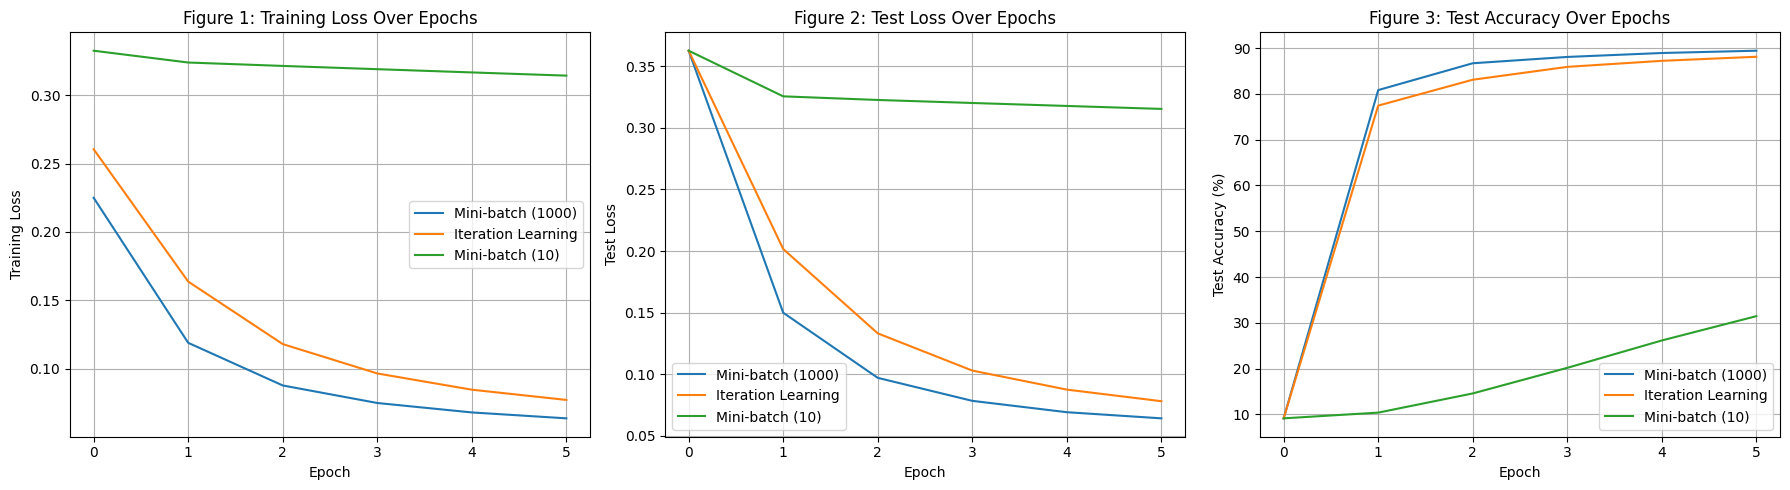

In [43]:
# Plotting code for Task 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
epochs = range(6)

# Figure 1: Training Loss Over Epochs
for label, logs in results.items():
    ax1.plot(epochs, logs['train_losses'], label=label)
ax1.set_title("Figure 1: Training Loss Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss")
ax1.legend()
ax1.grid()

# Figure 2: Test Loss Over Epochs
for label, logs in results.items():
    ax2.plot(epochs, logs['test_losses'], label=label)
ax2.set_title("Figure 2: Test Loss Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test Loss")
ax2.legend()
ax2.grid()

# Figure 3: Test Accuracy Over Epochs
for label, logs in results.items():
    test_accuracy = logs['test_corrects'] / x_test.shape[0] * 100
    ax3.plot(epochs, test_accuracy, label=label)
ax3.set_title("Figure 3: Test Accuracy Over Epochs")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Test Accuracy (%)")
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()

In [32]:
# Task 2 Experiment
def run_experiment(hidden_units, label):
    if hidden_units > 3136:
        rate_learning = 0.05
    else:
        rate_learning = 0.1

    PARAMETERS = {
        'WEIGHT_INIT': vs_init,
        'BIAS_INIT': zeros_init,
        'LEARNING_RATE': rate_learning,
        'MAX_EPOCHS': 25,
        'TRAINING_SIZE': x_train.shape[0],
        'TEST_SIZE': x_test.shape[0],
        'MINI_BATCH': 1000,
    }
    l_input = InputLayer(PARAMETERS, "input", 28 * 28)
    l_hidden = Layer(PARAMETERS, "hidden", hidden_units, sigmoid)
    l_output = Layer(PARAMETERS, "output", 10, softmax)
    global nn
    nn = l_input >> l_hidden >> l_output >> loss
    logs = nn.train_epochs(y_train, x_train, y_test, x_test)
    if logs is None:
        print(f"Experiment failed for {label} with {hidden_units} hidden units because of instability")
        return None, label
    logs['max_epochs'] = PARAMETERS['MAX_EPOCHS']
    return logs, label

# Run experiments with different hidden units
hidden_sizes = {
    "1/8x (98)": 784 // 8,
    "1/4x (196)": 784 // 4,
    "1/2x (392)": 784 // 2,
    "1x (784)": 784,
    "2x (1568)": 784 * 2,
    "4x (3136)": 784 * 4,
    "8x (6272)": 784 * 8
}

results = {}
for label, units in hidden_sizes.items():
    print(f"\nRunning {label} with {units} hidden units...")
    try:
        logs, _ = run_experiment(units, label)
        if logs is not None:
            results[label] = logs
        else:
            print(f"Skipping {label} due to failure")
    except Exception as e:
        print(f"Error in {label} with {units} hidden units: {str(e)}")


Running 1/8x (98) with 98 hidden units...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running 1/4x (196) with 196 hidden units...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running 1/2x (392) with 392 hidden units...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running 1x (784) with 784 hidden units...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running 2x (1568) with 1568 hidden units...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running 4x (3136) with 3136 hidden units...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running 8x (6272) with 6272 hidden units...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,


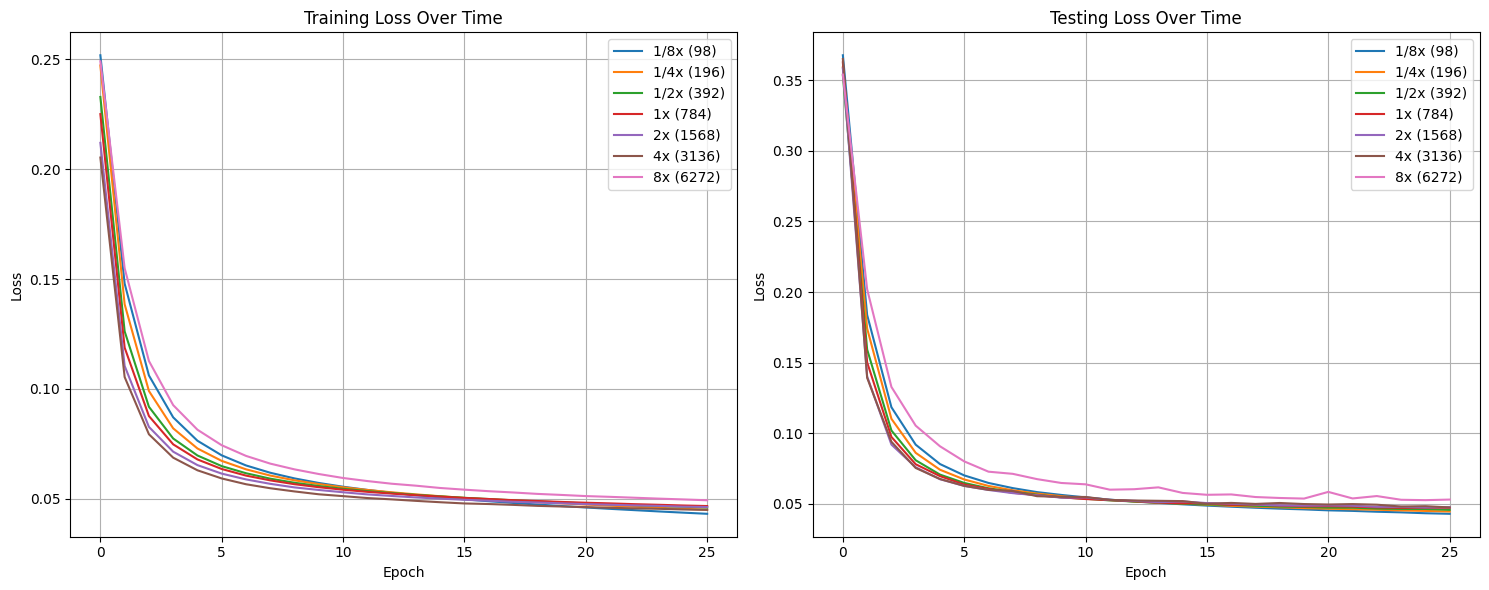

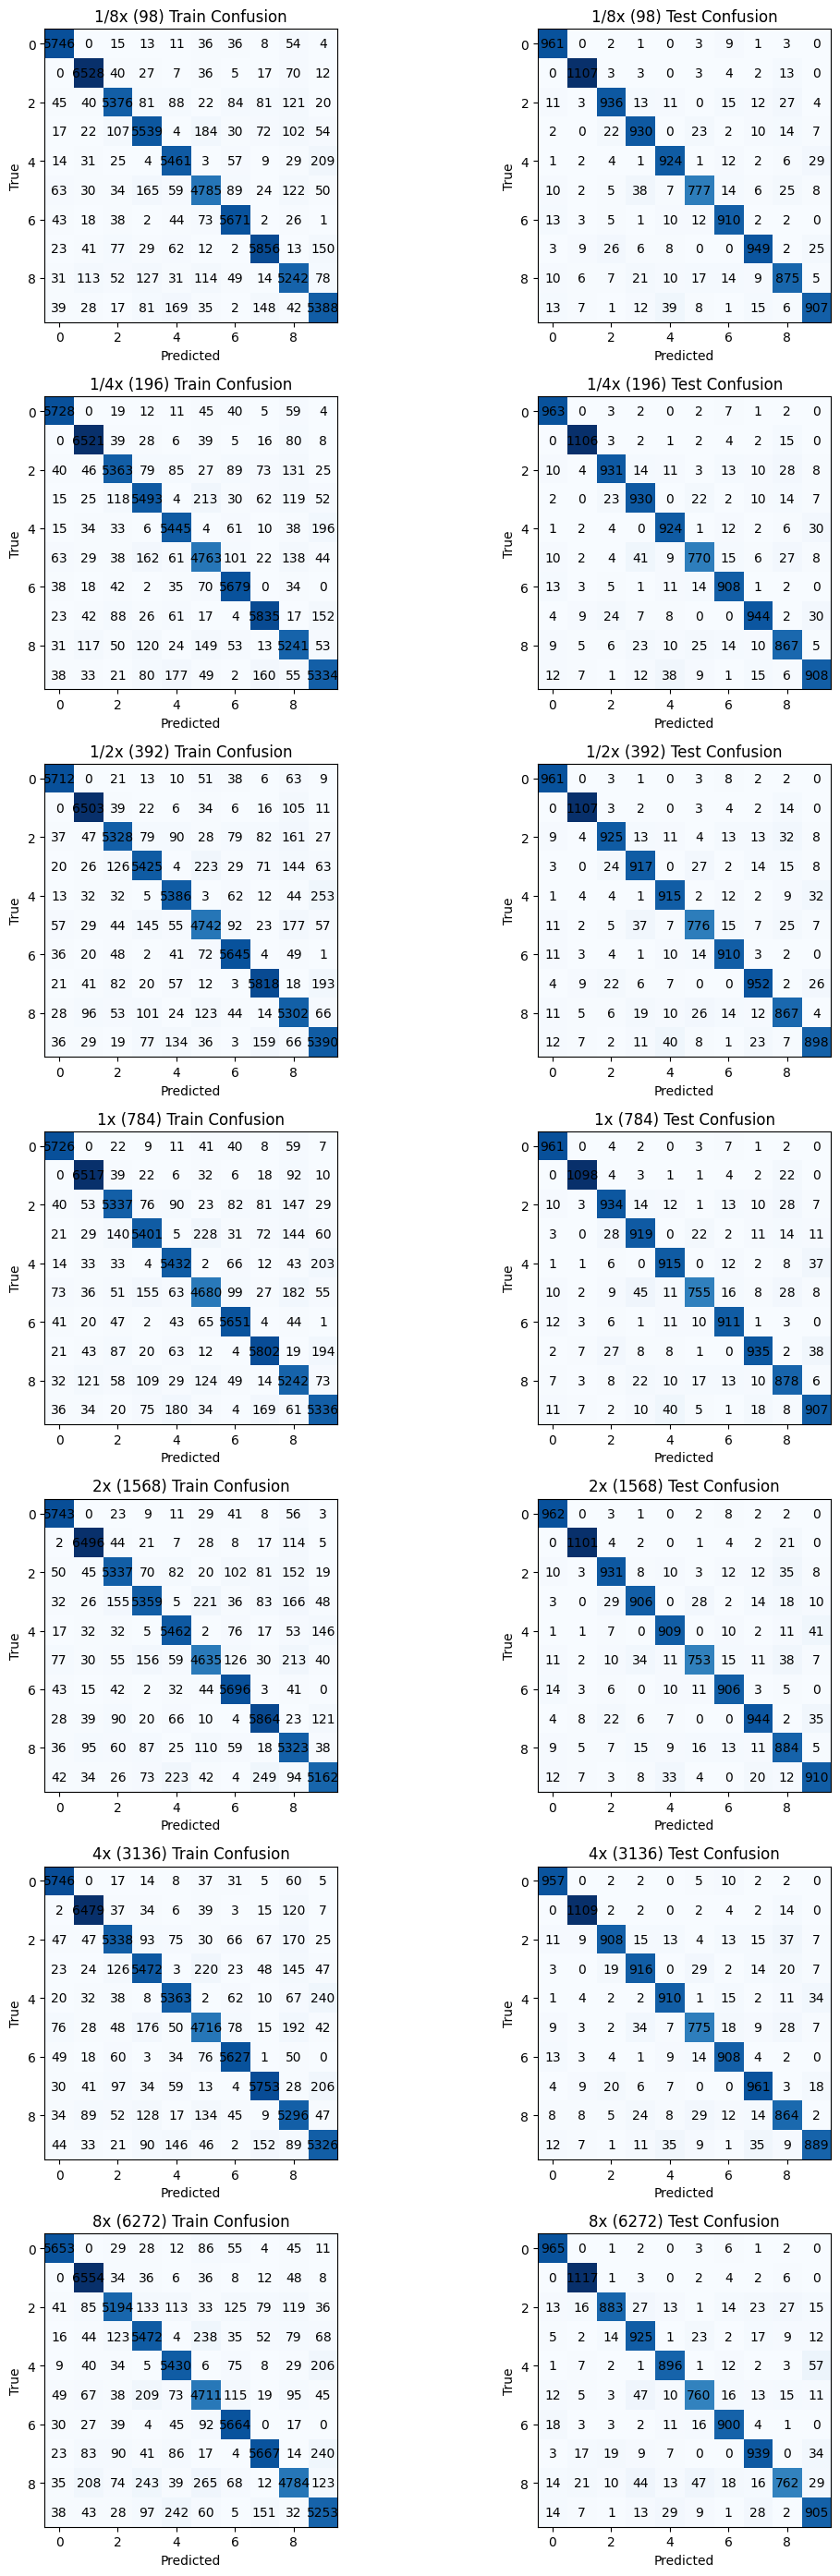


Performance Analysis:

1/8x (98):
  Final Training Accuracy: 0.9267
  Final Testing Accuracy: 0.9276
  Final Training Loss: 0.0432
  Final Testing Loss: 0.0430

1/4x (196):
  Final Training Accuracy: 0.9236
  Final Testing Accuracy: 0.9251
  Final Training Loss: 0.0451
  Final Testing Loss: 0.0446

1/2x (392):
  Final Training Accuracy: 0.9224
  Final Testing Accuracy: 0.9228
  Final Training Loss: 0.0461
  Final Testing Loss: 0.0458

1x (784):
  Final Training Accuracy: 0.9212
  Final Testing Accuracy: 0.9213
  Final Training Loss: 0.0468
  Final Testing Loss: 0.0472

2x (1568):
  Final Training Accuracy: 0.9230
  Final Testing Accuracy: 0.9206
  Final Training Loss: 0.0463
  Final Testing Loss: 0.0477

4x (3136):
  Final Training Accuracy: 0.9251
  Final Testing Accuracy: 0.9197
  Final Training Loss: 0.0450
  Final Testing Loss: 0.0475

8x (6272):
  Final Training Accuracy: 0.9178
  Final Testing Accuracy: 0.9052
  Final Training Loss: 0.0494
  Final Testing Loss: 0.0530


In [34]:
# Plotting for Task 2
def plot_losses(results):
    plt.figure(figsize=(15, 6))

    # Training Loss
    plt.subplot(1, 2, 1)
    for label, logs in results.items():
        epochs = range(logs['max_epochs'] + 1)
        plt.plot(epochs, logs['train_losses'], label=f'{label}')
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Testing Loss
    plt.subplot(1, 2, 2)
    for label, logs in results.items():
        epochs = range(logs['max_epochs'] + 1)
        plt.plot(epochs, logs['test_losses'], label=f'{label}')
    plt.title('Testing Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results):
    fig, axes = plt.subplots(len(results), 2, figsize=(12, 4 * len(results)))
    if len(results) == 1:
        axes = [axes]

    for idx, (label, logs) in enumerate(results.items()):
        # Training Confusion Matrix
        train_conf = logs['train_conf'].numpy()
        axes[idx][0].imshow(train_conf, cmap='Blues', interpolation='nearest')
        axes[idx][0].set_title(f'{label} Train Confusion')
        axes[idx][0].set_xlabel('Predicted')
        axes[idx][0].set_ylabel('True')
        for i in range(10):
            for j in range(10):
                axes[idx][0].text(j, i, train_conf[i, j], ha='center', va='center', color='black')

        # Testing Confusion Matrix
        test_conf = logs['test_conf'].numpy()
        axes[idx][1].imshow(test_conf, cmap='Blues', interpolation='nearest')
        axes[idx][1].set_title(f'{label} Test Confusion')
        axes[idx][1].set_xlabel('Predicted')
        axes[idx][1].set_ylabel('True')
        for i in range(10):
            for j in range(10):
                axes[idx][1].text(j, i, test_conf[i, j], ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

def analyze_results(results):
    print("\nPerformance Analysis:")
    best_test_acc = 0
    best_config = None

    for label, logs in results.items():
        train_acc = logs['train_corrects'][-1] / 60000
        test_acc = logs['test_corrects'][-1] / 10000
        final_train_loss = logs['train_losses'][-1]
        final_test_loss = logs['test_losses'][-1]

        print(f"\n{label}:")
        print(f"  Final Training Accuracy: {train_acc:.4f}")
        print(f"  Final Testing Accuracy: {test_acc:.4f}")
        print(f"  Final Training Loss: {final_train_loss:.4f}")
        print(f"  Final Testing Loss: {final_test_loss:.4f}")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_config = label

# Run the plotting and analysis
plot_losses(results)
plot_confusion_matrices(results)
analyze_results(results)

In [35]:
# Experiment Function for Task 3
def run_experiment(hidden1_units, hidden2_units, label):
    PARAMETERS = {
        'WEIGHT_INIT': vs_init,
        'BIAS_INIT': zeros_init,
        'LEARNING_RATE': 0.2,
        'MAX_EPOCHS': 25,
        'TRAINING_SIZE': x_train.shape[0],
        'TEST_SIZE': x_test.shape[0],
        'MINI_BATCH': 1000,
    }
    l_input = InputLayer(PARAMETERS, "input", 28 * 28)
    l_hidden1 = Layer(PARAMETERS, "hidden1", hidden1_units, sigmoid)
    l_hidden2 = Layer(PARAMETERS, "hidden2", hidden2_units, sigmoid)
    l_output = Layer(PARAMETERS, "output", 10, softmax)
    global nn
    nn = l_input >> l_hidden1 >> l_hidden2 >> l_output >> loss
    logs = nn.train_epochs(y_train, x_train, y_test, x_test)
    return logs, label

# Define the three networks
networks = [
    (490, 510, "Network 1: H1=490, H2=510 (~640,170 params)"),
    (400, 600, "Network 2: H1=400, H2=600 (~560,610 params)"),
    (600, 400, "Network 3: H1=600, H2=400 (~615,410 params)")
]

results = {}
for h1, h2, label in networks:
    print(f"\nRunning {label}...")
    logs, _ = run_experiment(h1, h2, label)
    results[label] = logs


Running Network 1: H1=490, H2=510 (~640,170 params)...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running Network 2: H1=400, H2=600 (~560,610 params)...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

Running Network 3: H1=600, H2=400 (~615,410 params)...
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,


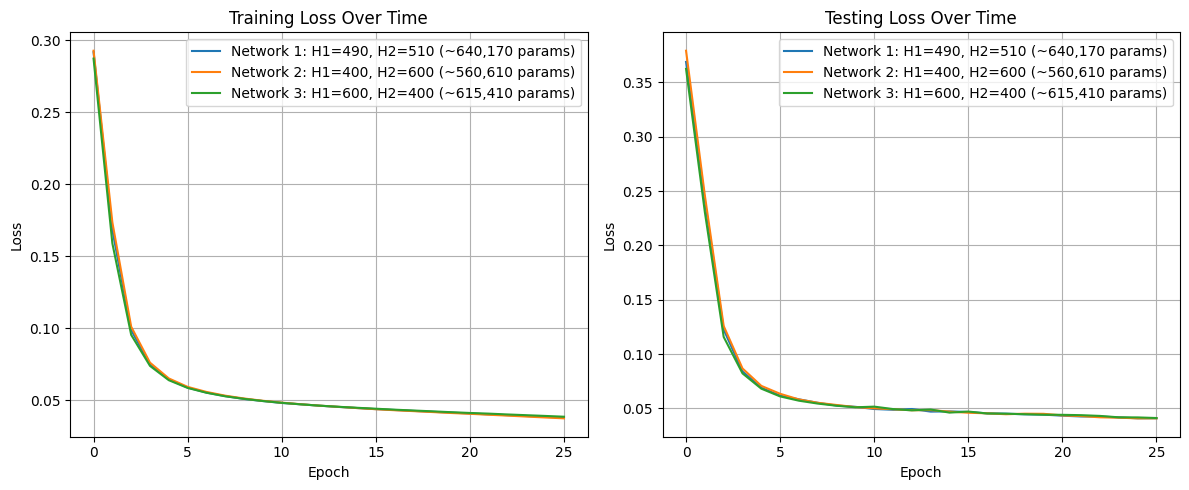

In [36]:
# Plotting Task 3
def plot_losses(results):
    plt.figure(figsize=(12, 5))

    # Training Loss
    plt.subplot(1, 2, 1)
    for label, logs in results.items():
        epochs = range(len(logs['train_losses']))
        plt.plot(epochs, logs['train_losses'], label=label)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Testing Loss
    plt.subplot(1, 2, 2)
    for label, logs in results.items():
        epochs = range(len(logs['test_losses']))
        plt.plot(epochs, logs['test_losses'], label=label)
    plt.title('Testing Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the plotting
plot_losses(results)

unshuffled


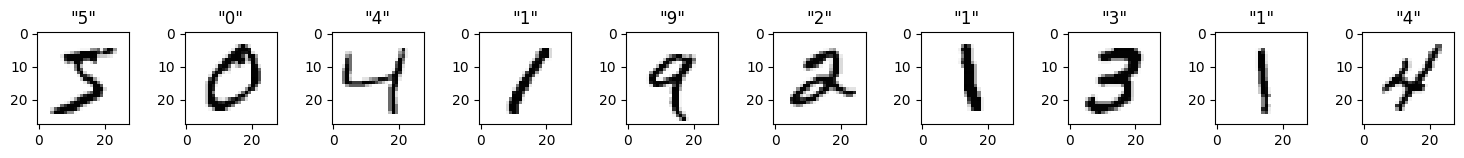

shuffled


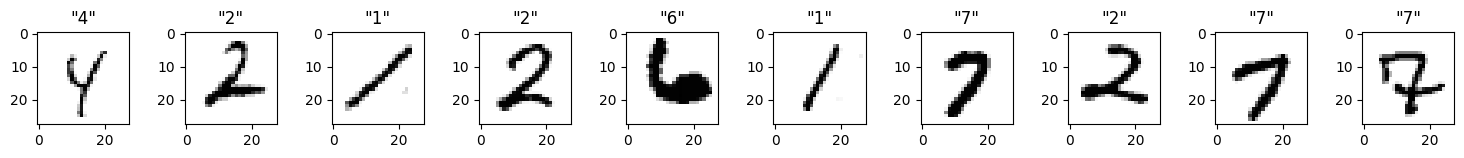

In [ ]:
import matplotlib.pyplot as plt;

"""
Test the double_shuffle function.

Shuffle the data, then print out 10 numbers from the unshuffled data and the shuffled data
to show that the labels match the images and the suffled numbers are shuffled.
"""
x2,y2 = double_shuffle(x_train,y_train);


def show10(x_train,y_train):
    # 1 x 10 plot output
    fig, axs = plt.subplots(1,10,figsize=(15,16));

    for idx in range(10):
        axs[idx].imshow( x_train[idx], cmap='Greys', interpolation='nearest');
        axs[idx].set( title="\""+str(y_train[idx])+"\"" );
    fig.tight_layout(pad=2.0);
    plt.show();

print( "unshuffled" );
show10(x_train,y_train);

print( "shuffled" );
show10(x2,y2);

In [ ]:
def show_results( params, logs ):
    """
    This function visualizes the results of the training.
    """

    MB_SIZE = params['TRAINING_SIZE']//params['MINI_BATCH'];

    fig, axs = plt.subplots(6,figsize=(15,45));

    epochs = range(0,params['MAX_EPOCHS']+1);
    batches = range(0,(params['MAX_EPOCHS']+1)*params['MINI_BATCH']);

    losses_per_batch = np.reshape( logs["losses"],
                                   [ (params['MAX_EPOCHS']+1) * \
                                      params['MINI_BATCH'] ] );

    l, = axs[0].plot( batches, losses_per_batch );
    axs[0].set(xlabel=r'batch', ylabel=r'loss',
           title='Loss', ylim=(0,0.45)  );
    axs[0].grid();

    l, = axs[1].plot( epochs, np.mean( logs["losses"], 1 ) );
    axs[1].set(xlabel=r'epoch', ylabel=r'loss',
           title='Average Loss', ylim=(0,0.45)  );
    axs[1].grid();

    corrects_per_batch = np.reshape( logs["corrects"],
                                     [ (params['MAX_EPOCHS']+1) * \
                                        params['MINI_BATCH']] );

    l, = axs[2].plot( batches, corrects_per_batch );
    axs[2].set(xlabel=r'batch', ylabel=r'correct',
           title='Correct', ylim=(0,MB_SIZE) );
    axs[2].grid();

    l, = axs[3].plot( epochs, np.sum( logs["corrects"], 1 ) );
    axs[3].set(xlabel=r'epoch', ylabel=r'correct',
           title='Total Correct', ylim=(0,params['TRAINING_SIZE']) );
    axs[3].grid();

    l, = axs[4].plot( epochs, logs["test_losses"] );
    axs[4].set(xlabel=r'epochs', ylabel=r'loss',
           title='Test Loss', ylim=(0,0.45));
    axs[4].grid();

    l, = axs[5].plot( epochs, logs["test_corrects"] );
    axs[5].set(xlabel=r'epoch', ylabel=r'correct',
           title='Test Correct', ylim=(0,params['TEST_SIZE']) );
    axs[5].grid();



    fig.tight_layout(pad=2.0);
    plt.show();

    print( "Confusion matrix of test data:" );
    print( logs["test_conf"] );
    print();
    print( "Total time: %s" % (logs["total_time"],) );
    print( "Epochs/s: %s" % (params['MAX_EPOCHS']/logs["total_time"],) );
    print( "Updates/s: %s" % (params['MAX_EPOCHS']*params['MINI_BATCH']/logs["total_time"],) );

    print( "Training Examples/Update: %s" % (MB_SIZE,) );


# Network 1:  
## Run-time:
## 259s on T4 GPU
## 451s on Cv2-8 TPU
## 539s on CPU

In [ ]:
# Mini-batch learning
##########################################################################
# This updates the weights after presentation a mini-batch training
# data.  The size of the minibatch is 1/1000 of the entire training data,
# in this case 60 examples.
# It requires few epochs, but runs inefficiently on the GPU.
##########################################################################
##########################################################################
# Parameters

DTYPE = tf.float32;

PARAMETERS1 = {


    'WEIGHT_INIT' : vs_init,
    'BIAS_INIT' : zeros_init,

    'LEARNING_RATE' : 0.2,


    'MAX_EPOCHS' : 25,     # maximum number of epochs to run
    'TRAINING_SIZE' : x_train.shape[0], # number of training examples
    'TEST_SIZE' : x_test.shape[0], # number of testing examples


    # use this for mini-batch learning
    'MINI_BATCH' : 1000,   # number of mini_batches per epoch

    # use this for iteration learning
    #'MINI_BATCH' : x_train.shape[0],

    # use this for epoch learning
    #'MINI_BATCH' : 1,


};


##########################################################################
##########################################################################



# build the network

input_l  = InputLayer( PARAMETERS1, "input", 28*28 );
hidden_l = Layer( PARAMETERS1, "hidden", 28*28, sigmoid );
output_l = Layer( PARAMETERS1, "output", 10, softmax );

nn = input_l >> hidden_l >> output_l >> loss;

# train it
logs1 = nn.train_epochs( y_train, x_train, y_test, x_test );

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,


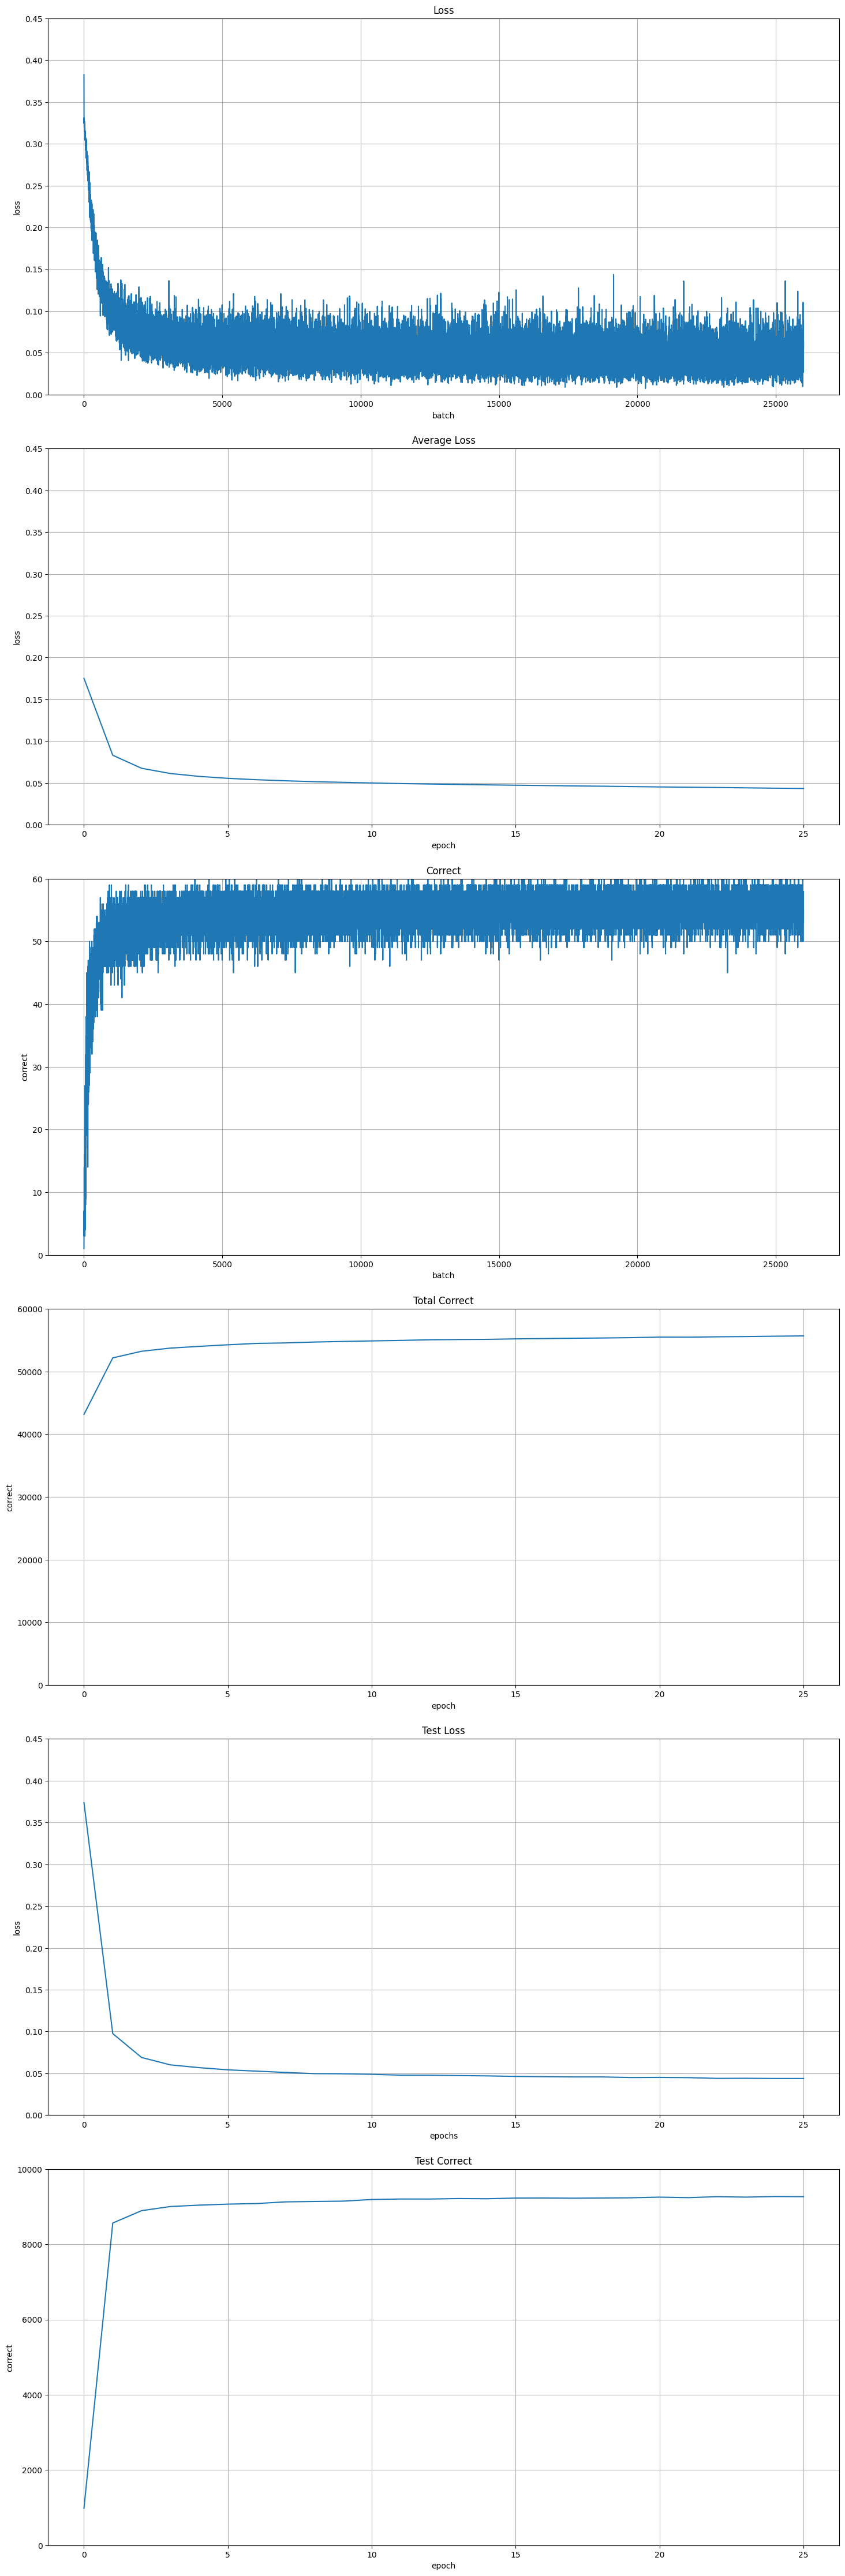

Confusion matrix of test data:
tf.Tensor(
[[ 960    0    1    2    0    3   10    2    2    0]
 [   0 1105    3    2    0    2    4    2   17    0]
 [   9    4  914   19    8    3   16   11   40    8]
 [   2    0   12  935    0   18    2   10   25    6]
 [   1    3    2    3  917    0   14    2   11   29]
 [   9    1    1   39    9  768   18    6   34    7]
 [  12    3    4    1    9    9  914    2    4    0]
 [   3    6   21    7    7    1    0  952    3   28]
 [   7    4    3   18    8   18   11    9  893    3]
 [  11    6    1   11   34    6    0   21   12  907]], shape=(10, 10), dtype=int32)

Total time: 287.17381620407104
Epochs/s: 0.0870552905221503
Updates/s: 87.0552905221503
Training Examples/Update: 60


In [ ]:
show_results( PARAMETERS1, logs1 );